## LMP predictions

This notebook shows how to access, navigate and analyze data from backtest predictions for the Day Ahead trading in MISO market. Predictions are calculated with model trained on data excluding the period for which predictions are given.

The few-line trading algorithm included at the end is entirely based on the DA, RT and trading probability predictions. There are several options in the code comments, allowing to turn off the usage of each quantity. You can also play with the parameters, e.g. change the probability threshold value and verify stability of the algorithm.

Contact us for any further questions!

contact@crystalball24.com

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import requests
import json
import io

### Read data from server

In [2]:
# your access configuration:
config_file = 'access_config.json'

with open(config_file, 'r') as f: config = json.load(f)
addr = config['address']
folder = config['backtest_folder']

# backtest data file:
filename = 'miso_g9_2018_bt.csv'  # 10/2017 - 10/2018
#filename = 'miso_g9_2017_bt.csv' # 10/2016 - 10/2017

url_crystalball24 = 'http://{0}/{1}/{2}'.format(addr, folder, filename)
try:
    print('Downloading data...')
    r = requests.get(url_crystalball24, timeout=20)
    with io.StringIO(r.text) as f:
        bt = pd.read_csv(f)
    print('...done.')
except:
    print('Problem with reading from Crystalball24.com')
    
print(bt.columns.values)

...done.
['date' 'hour' 'node' 'true_dalmp' 'true_spread' 'pred_dalmp' 'pred_rtlmp'
 'probability']


#### Reshape data for convenience, estimate predictions threshold

In [3]:
n_nodes = bt.node.nunique()
n_days = int(bt.shape[0] / n_nodes / 24)
print('Nodes:', n_nodes, ', days:', n_days)

dates = bt.date.values.reshape((n_days, 24, n_nodes))
hours = bt.hour.values.reshape((n_days, 24, n_nodes))
node = bt.node.values.reshape((n_days, 24, n_nodes))
true_dalmp = bt.true_dalmp.values.reshape((n_days, 24, n_nodes))
true_spread = bt.true_spread.values.reshape((n_days, 24, n_nodes))
pred_dalmp = bt.pred_dalmp.values.reshape((n_days, 24, n_nodes))
pred_rtlmp = bt.pred_rtlmp.values.reshape((n_days, 24, n_nodes))
probability = bt.probability.values.reshape((n_days, 24, n_nodes))

pmax = np.percentile(bt.probability.values, 99.8)
phigh = np.percentile(bt.probability.values, 94.0)
thr = 0.5 * (0.7 * pmax + phigh)
print('Use threshold', np.round(thr,2))

Nodes: 32 , days: 372
Use threshold 0.68


### Inspect one day / one node predictions

<IPython.core.display.Javascript object>


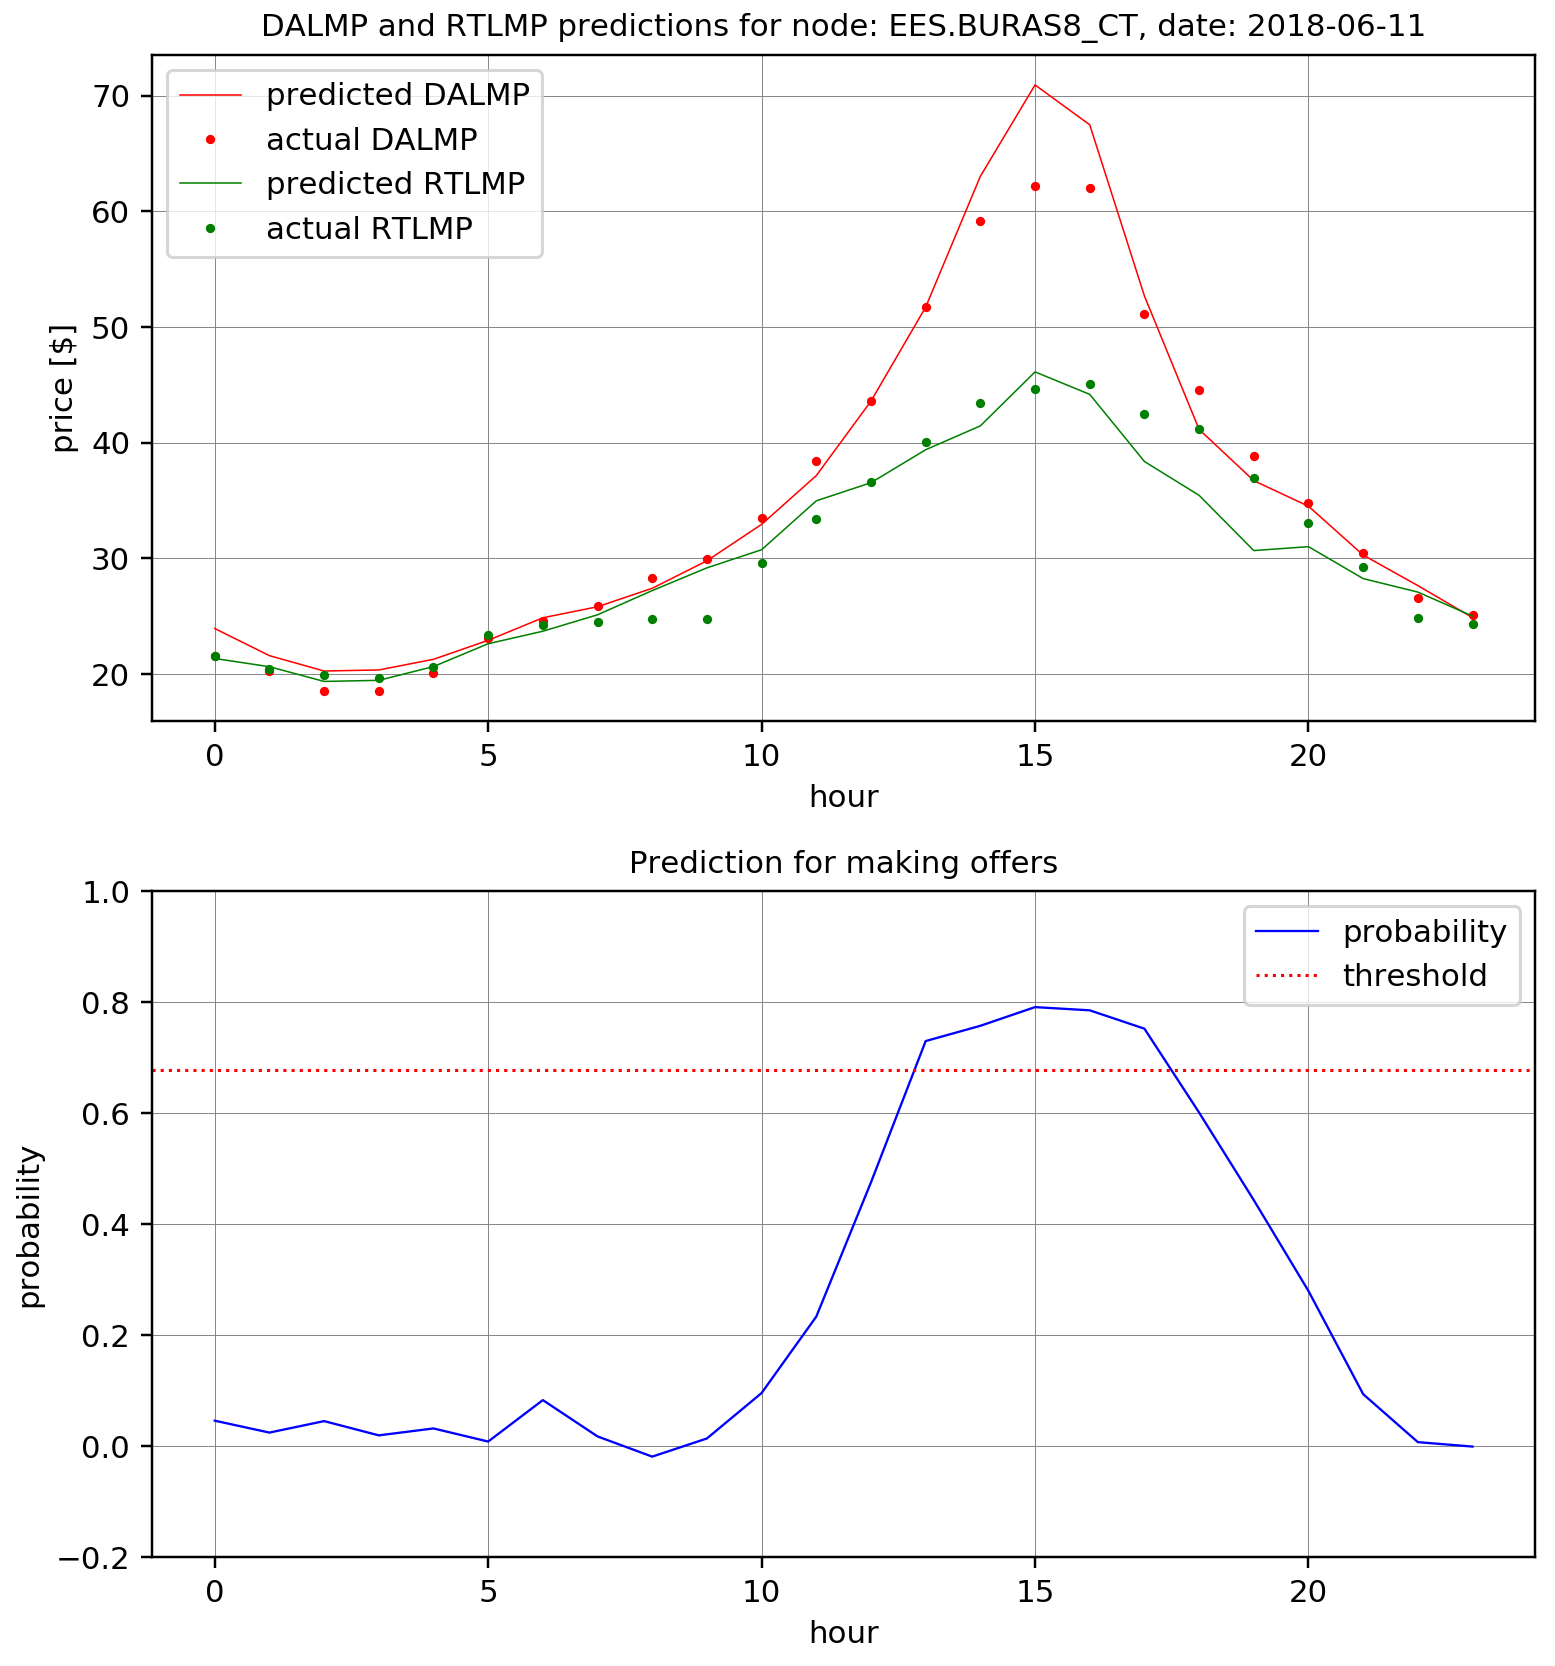

In [4]:
day = 249
n = 20

plt.figure(1, figsize=(7,7.5))

plt.subplot(211)
plt.title('DALMP and RTLMP predictions for node: {0}, date: {1}'.format(node[day,0,n], dates[day,0,n]), fontsize=10)
plt.plot(pred_dalmp[day,:,n], '-', color='red', linewidth=0.5, label='predicted DALMP')
plt.plot(true_dalmp[day,:,n], '.', color='red', markersize=4, label='actual DALMP')
plt.plot(pred_rtlmp[day,:,n], '-', color='green', linewidth=0.5, label='predicted RTLMP')
plt.plot(true_dalmp[day,:,n]+true_spread[day,:,0], '.', color='green', markersize=4, label='actual RTLMP')
plt.grid(color='grey', linestyle='-', linewidth=0.3)
plt.xlabel('hour')
plt.ylabel('price [$]')
plt.legend(loc='upper left')

plt.subplot(212)
plt.title('Prediction for making offers', fontsize=10)
plt.plot(probability[day,:,n], '-', color='blue', linewidth=0.75, label='probability')
plt.axhline(thr, color='red', linestyle='dotted', linewidth=1, label='threshold')
plt.grid(color='grey', linestyle='-', linewidth=0.3)
plt.xlabel('hour')
plt.ylabel('probability')
plt.ylim(-0.2,1)
plt.legend()

plt.tight_layout(pad=0.4, w_pad=0.75, h_pad=1.0)
plt.show()

### Examine all days / all nodes

<IPython.core.display.Javascript object>


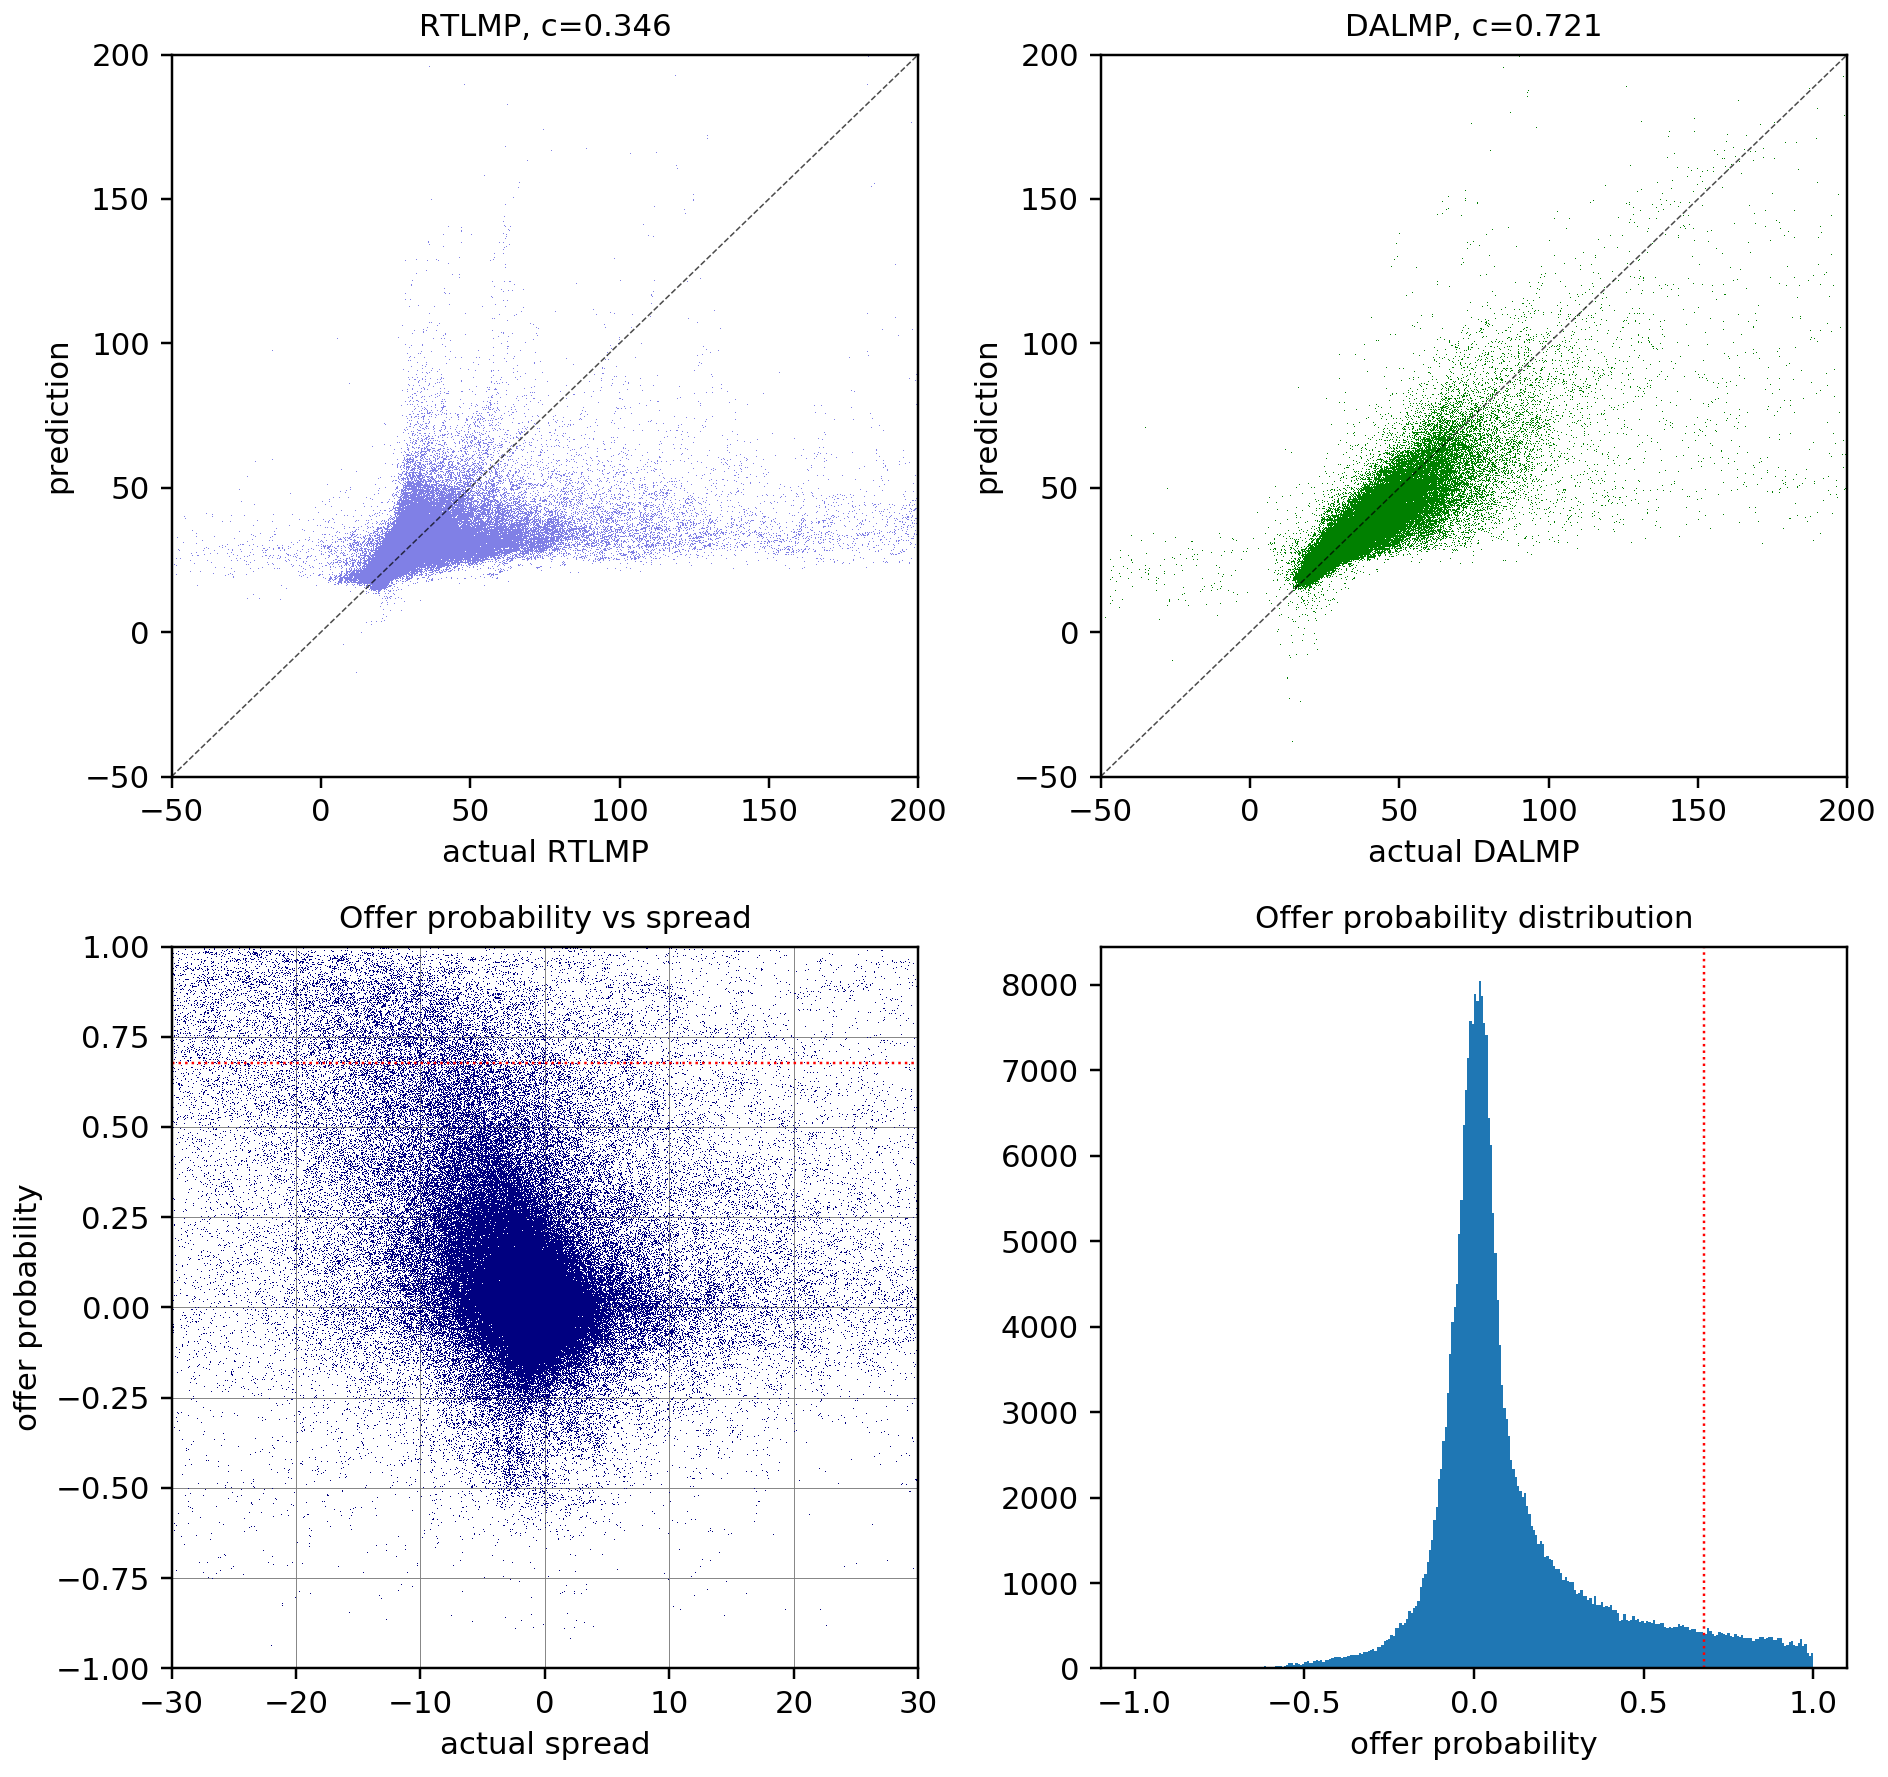

In [5]:
true_rt = bt.true_dalmp.values+bt.true_spread.values
rt_pred_corr = np.corrcoef(true_rt, bt.pred_rtlmp.values)[0,1]
da_pred_corr = np.corrcoef(bt.true_dalmp.values, bt.pred_dalmp.values)[0,1]

plt.figure(2, figsize=(8.5,8))
ax = plt.subplot(221)
plt.title('RTLMP, c='+str(np.round(rt_pred_corr, 3)), fontsize=10)
plt.plot(true_rt, bt.pred_rtlmp.values, ',', color=(0.5, 0.5, 0.9))
plt.xlim(-50,200)
plt.ylim(-50,200)
plt.plot(ax.get_xlim(), ax.get_ylim(), color='black', alpha=0.7, linewidth=0.5, ls="--")
plt.xlabel('actual RTLMP')
plt.ylabel('prediction')

ax = plt.subplot(222)
plt.title('DALMP, c='+str(np.round(da_pred_corr, 3)), fontsize=10)
plt.plot(bt.true_dalmp.values, bt.pred_dalmp.values, ',', color=(0, 0.5, 0))
plt.xlim(-50,200)
plt.ylim(-50,200)
plt.plot(ax.get_xlim(), ax.get_ylim(), color='black', alpha=0.7, linewidth=0.5, ls="--")
plt.xlabel('actual DALMP')
plt.ylabel('prediction')

plt.subplot(223)
plt.title('Offer probability vs spread', fontsize=10)
plt.plot(bt.true_spread.values, bt.probability.values, ',', markersize=0.1, color=(0,0,0.5))
plt.axhline(thr, color='red', linestyle='dotted', linewidth=0.8)
plt.grid(color='grey', linestyle='-', linewidth=0.3)
plt.xlim(-30,30)
plt.ylim(-1,1)
plt.xlabel('actual spread')
plt.ylabel('offer probability')

plt.subplot(224)
plt.title('Offer probability distribution', fontsize=10)
plt.hist(bt.probability.values, bins=300, range=(-1,1))
plt.axvline(thr, color='red', linestyle='dotted', linewidth=0.8)
plt.xlabel('offer probability')

plt.tight_layout(pad=0.4, w_pad=0.75, h_pad=1.0)
plt.show()

### Example trading parameters

In [6]:
# Initial capital, let's say $1M:
capital = 1e+6
# Safe, 10% exposure, so target using max $100k each day:
exposure = 0.1

daily_volume = exposure * capital
max_virtual_pct = 0.02 # max 2% volume on a single hour/node
threshold = thr+0.05 # to ensure stability of result try also: thr +/- 0.05
offer_fee = 0.5
price_margin = 2
trade = -1 # offers gain on the negative spread (use +1 for bids)

### Run backtest

In [7]:
# MW allocation based on Neural Network predictions.
# You can still run naive backtest with this function
# commented out, just enable constant MW allocation below.
from utils.allocators import allocate_offer_mw

In [8]:
pnl_daily = np.zeros(n_days, dtype=np.float32)
usd_daily = np.zeros(n_days, dtype=np.float32)
mw_daily = np.zeros(n_days, dtype=np.float32)
winning_count = 0
all_virtuals = 0
op_day = []

print('date\t\t desired\t executed\t total MW\t total $\t PNL\t\t [%]')
for d in range(n_days):
    op_day.append(dates[d,0,0])
    p = probability[d]
    da = pred_dalmp[d]
    rt = pred_rtlmp[d]
    
    tda = true_dalmp[d]
    tspread = true_spread[d]
    
    # allocate MW using NN predictions:
    virtual_mw = allocate_offer_mw(p, p_threshold=threshold,
                                   daily_volume=daily_volume,
                                   max_pct=max_virtual_pct,
                                   da=da)
    # or pick a constant MW and put it on each hour/node:
    #virtual_mw = np.full(p.shape, 5) # [MW]
    
    go_idx = virtual_mw > 0
    go_count = go_idx.sum()
    if go_count == 0: continue
    
    # use RT prediction for a simple price managment:
    exec_idx = go_idx & (tda > rt + price_margin)
    
    # or price taker: no use of RT prediction:
    #exec_idx = go_idx
    
    winning_count += ((trade*tspread[exec_idx] - offer_fee) > 0).sum()
    all_virtuals += exec_idx.sum()

    pnl_daily[d] = ((trade*tspread[exec_idx] - offer_fee) * virtual_mw[exec_idx]).sum()
    usd_daily[d] = (virtual_mw[exec_idx] * tda[exec_idx] + offer_fee).sum()
    mw_daily[d] = virtual_mw.sum()
    
    print(op_day[d], '\t', go_count, '\t\t', exec_idx.sum(),
          '\t\t', np.round(mw_daily[d],1), '   \t', np.round(usd_daily[d],1),
          '   \t', np.round(pnl_daily[d],1), '   \t', np.round(100*pnl_daily[d]/capital,2))

date		 desired	 executed	 total MW	 total $	 PNL		 [%]
2017-10-05 	 17 		 17 		 631.5    	 32941.6    	 7850.3    	 0.79
2017-10-06 	 17 		 16 		 601.9    	 29669.4    	 6807.5    	 0.68
2017-10-07 	 142 		 140 		 2028.6    	 92347.6    	 17872.8    	 1.79
2017-10-09 	 2 		 2 		 63.0    	 3437.7    	 -136.8    	 -0.01
2017-10-10 	 95 		 95 		 1780.3    	 109938.8    	 48058.3    	 4.81
2017-10-13 	 10 		 10 		 390.0    	 25283.9    	 3844.9    	 0.38
2017-10-14 	 6 		 6 		 245.3    	 18158.5    	 6046.3    	 0.6
2017-10-15 	 4 		 4 		 152.9    	 8604.1    	 3771.7    	 0.38
2017-10-19 	 4 		 3 		 184.9    	 4995.3    	 978.8    	 0.1
2017-10-20 	 2 		 2 		 101.8    	 4065.3    	 1603.0    	 0.16
2017-10-23 	 60 		 60 		 2818.2    	 91701.7    	 22330.3    	 2.23
2017-10-27 	 115 		 115 		 2914.5    	 92548.0    	 14361.9    	 1.44
2017-11-05 	 4 		 4 		 221.0    	 8780.5    	 -1371.3    	 -0.14
2017-11-06 	 71 		 71 		 2129.5    	 117182.8    	 -7601.3    	 -0.76
2017-11-07 	 11 		 11 

<IPython.core.display.Javascript object>


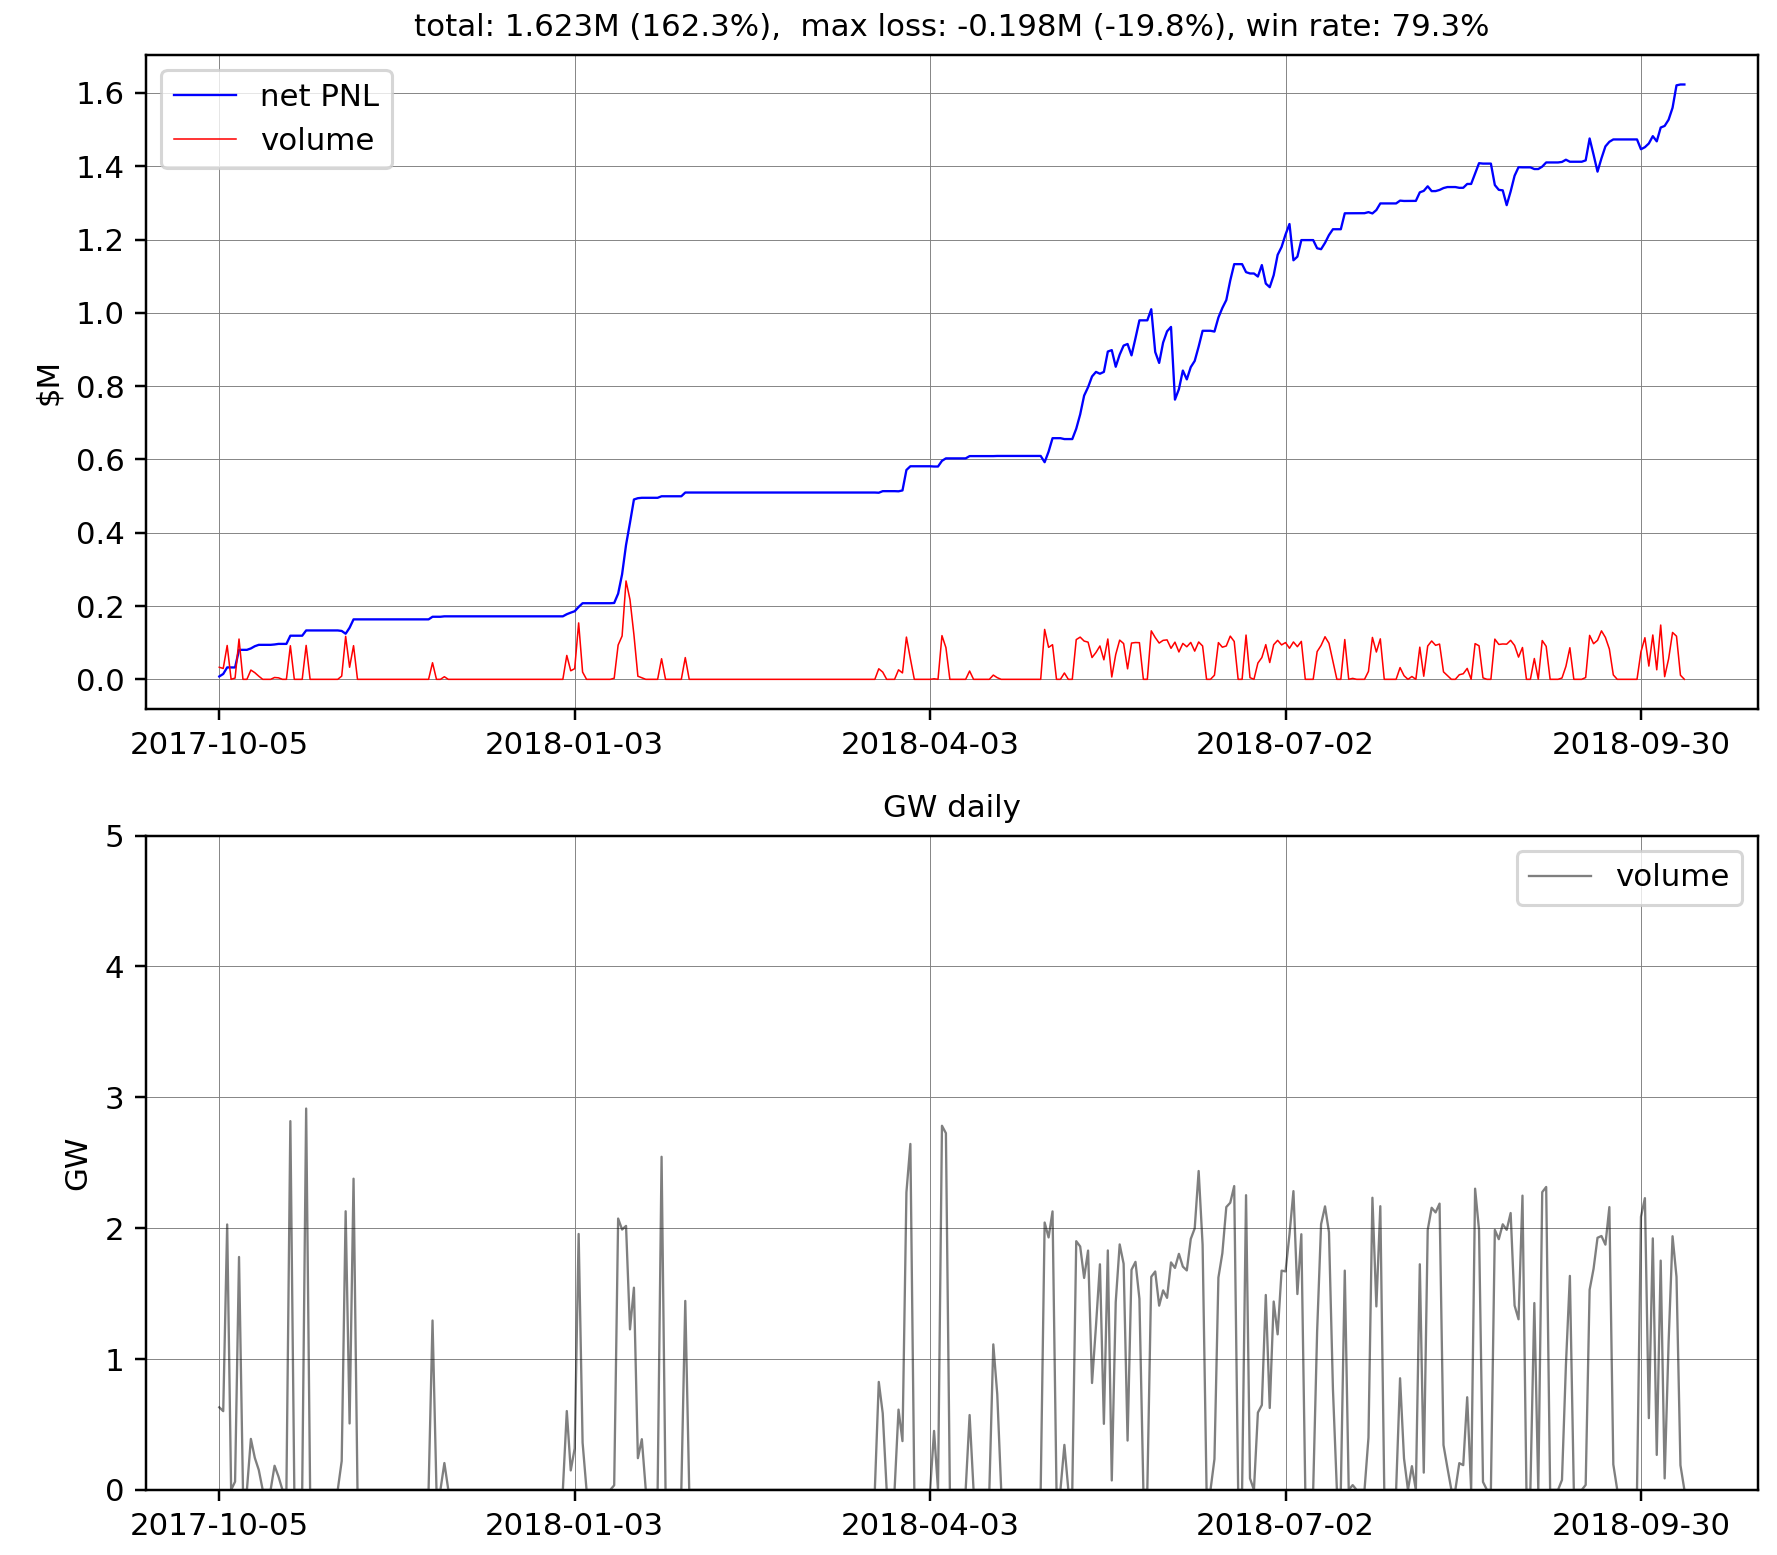

In [9]:
win_rate = np.round(100 * winning_count/all_virtuals, 1)
tot_usd = np.round(np.cumsum(pnl_daily)[-1] * 1e-6,3)
tot_pct = np.round(100 * np.cumsum(pnl_daily)[-1] / capital,1)
max_loss_usd = np.round(np.amin(pnl_daily) * 1e-6,3)
max_loss_pct = np.round(100 * np.amin(pnl_daily) / capital,1)

days = np.arange(len(op_day))
ticks = np.arange(len(op_day), step=90)
labels = [op_day[d] for d in ticks]

plt.figure(3, figsize=(8,7))

plt.subplot(211)
plt.title('total: {0}M ({1}%),  max loss: {2}M ({3}%), win rate: {4}%'.format(tot_usd,tot_pct,max_loss_usd,max_loss_pct,win_rate), fontsize=10)
plt.plot(1e-6 * np.cumsum(pnl_daily), '-', color='blue', linewidth=0.75, label='net PNL')
plt.plot(1e-6 * usd_daily, '-', color='red', linewidth=0.5, label='volume')
plt.grid(color='grey', linestyle='-', linewidth=0.3)
plt.xticks(ticks, labels)
plt.ylabel('$M')
plt.legend()

plt.subplot(212)
plt.title('GW daily', fontsize=10)
plt.plot(1e-3*mw_daily, '-', color='black', alpha=0.5, linewidth=0.75, label='volume')
plt.grid(color='grey', linestyle='-', linewidth=0.3)
plt.xticks(ticks, labels)
plt.ylabel('GW')
plt.ylim(0,5)
plt.legend()

plt.tight_layout(pad=0.4, w_pad=0.75, h_pad=1.0)
plt.show()